In [2]:
import pandas as pd
raw_data = pd.read_csv('train.csv')
raw_data['datetime'] = raw_data['datetime'].apply(pd.to_datetime)
df_px = raw_data[['datetime', 'count']].copy()
df_px.rename(columns={'datetime': 'ds', 'count': 'y'}, inplace=True)


In [3]:
num = 24*14
train, test = df_px.iloc[:-num,:], df_px.iloc[-num:,:]

In [4]:
!pip install pystan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.3 MB/s eta 0:00:00


In [5]:
!pip install prophet

In [6]:
!pip install keras==2.12.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime
from xgboost import XGBRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, \
mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV


In [8]:
m = Prophet(
                growth='linear',
                seasonality_mode='additive',
                interval_width=0.95,
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=False
            )
m.fit(train)


DEBUG:cmdstanpy:input tempfile: /tmp/tmptlujveg5/bbi8gdcq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptlujveg5/_k2kelcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91398', 'data', 'file=/tmp/tmptlujveg5/bbi8gdcq.json', 'init=/tmp/tmptlujveg5/_k2kelcl.json', 'output', 'file=/tmp/tmptlujveg5/prophet_modelp_zuj0hc/prophet_model-20240604024853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:48:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:48:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:

predictions_train = m.predict(train.drop('y', axis=1))
predictions_test = m.predict(test.drop('y', axis=1))
predictions = pd.concat([predictions_train, predictions_test], axis=0)


In [10]:
# use the results of the prophet as features
df = pd.merge(raw_data, predictions, left_on=['datetime'], right_on=['ds'], how='inner')
df.drop('ds', axis=1, inplace=True)
df.set_index('datetime', inplace=True)


In [11]:
# made lags
for lag in range(1,6):
    df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag)

In [12]:
# make XGBR
X = df.drop('count', axis=1)
y = df['count']

In [13]:
X_train, X_test = X.iloc[:-num,:], X.iloc[-num:,:]
y_train, y_test = y.iloc[:-num], y.iloc[-num:]

In [14]:
# fit model
model_xgbr = XGBRegressor(random_state=0)
model_xgbr.fit(X_train, y_train)

# predict
pre_y = model_xgbr.predict(X_test)

In [15]:
# evaluation
model_metrics_functions = [explained_variance_score, mean_absolute_error, mean_squared_error,r2_score]
model_metrics_list = [[m(y_test, pre_y) for m in model_metrics_functions]]
regresstion_score = pd.DataFrame(model_metrics_list, index=['model_xgbr'],
                   columns=['explained_variance', 'mae', 'mse', 'r2'])
regresstion_score


,explained_variance,mae,mse,r2
model_xgbr,0.99952,2.23657,14.16819,0.99952


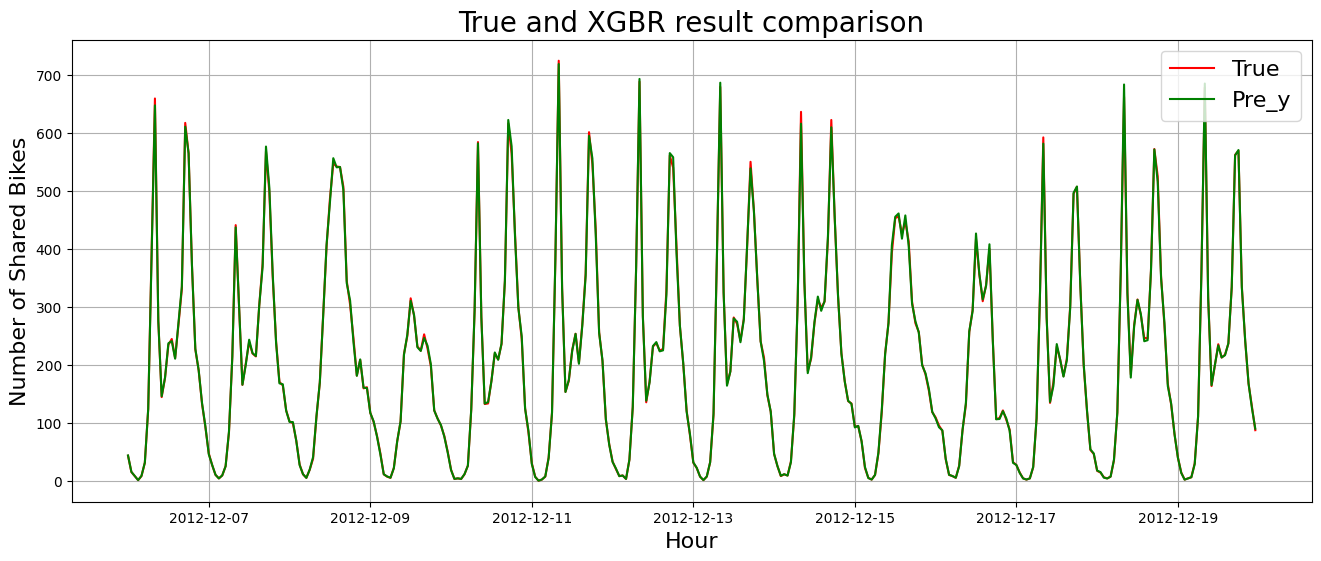

In [16]:
fig = plt.figure(figsize=(16,6))
plt.title('True and XGBR result comparison', fontsize=20)
plt.plot(y_test, color='red')
plt.plot(pd.Series(pre_y, index=y_test.index), color='green')
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Number of Shared Bikes', fontsize=16)
plt.legend(labels=['True', 'Pre_y'], fontsize=16)
plt.grid()
plt.show()


In [17]:
features = X.columns
importances = model_xgbr.feature_importances_

importances_df = pd.DataFrame()
importances_df['features'] = features
importances_df['importance'] = importances
importances_df = importances_df.sort_values('importance', ascending=False)
importances_df.head(10)


,features,importance
9,registered,0.937543
8,casual,0.060082
32,yhat_lag_5,0.000235
10,trend,0.000182
18,daily,0.000158
29,yhat_lag_2,0.000158
21,weekly,0.000155
7,windspeed,0.000152
15,additive_terms,0.000137
30,yhat_lag_3,0.000131
